### Clone utilities

In [ ]:
!git clone https://github.com/marcin119a/lstm-pycbc.git
%cd lstm-pycbc

Cloning into 'lstm-pycbc'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 163 (delta 78), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (163/163), 9.15 MiB | 7.13 MiB/s, done.
Resolving deltas: 100% (78/78), done.
/content/lstm-pycbc/lstm-pycbc


In [1]:
%%capture
!pip install -r requirements.txt

### Generate dataset, m1 -- first mass of black hole, m2 -- second mass of black hole, -n  -- numbers of signals, -time_steps -- lengh of signal

In [2]:
!python dump_dataset.py -m1=10 -m2=20 -n=100 -time_steps=1200

2020-09-28 09:46:27.645555: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


### Import dataset


In [3]:
import hickle as hkl


array_hkl = hkl.load('/home/marcin119a/lstm-pycbc/data/D-SET-norm(100,1200).hkl')
X_train = array_hkl.get('xtrain')
X_test = array_hkl.get('xtest')
y_train = array_hkl.get('ytrain')
y_test = array_hkl.get('ytest')

In [4]:
X_train.shape

(67, 1, 1200)

In [48]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [54]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    scalers[i].fit_transform(X_train[:, i, :])
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 


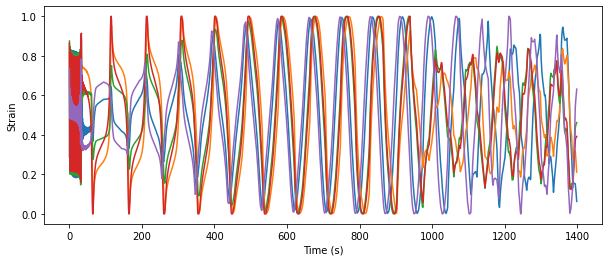

In [56]:
import pylab 
pylab.figure(figsize=(10,4))
for x in range(0,5):
  pylab.plot(X_train[x])
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

In [12]:
array_hkl = hkl.load('data/D-SET(100,1200).hkl')
X_train = array_hkl.get('xtrain')
X_test = array_hkl.get('xtest')
y_train = array_hkl.get('ytrain')
y_test = array_hkl.get('ytest')

#X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], 1)
#X_train.shape

In [13]:
X_train

array([[[ 9.86764048e-06, -1.89856365e-05,  2.94593338e-05, ...,
         -3.64191038e-03, -7.26806644e-03, -1.08501048e-02]],

       [[ 4.43282830e-06, -4.78985212e-06,  9.47773988e-06, ...,
         -3.05920432e-02, -3.32903452e-02, -3.57676185e-02]],

       [[ 1.06056008e-05, -1.77487974e-05,  2.89752332e-05, ...,
          2.75466873e-02,  3.23397496e-02,  3.67438397e-02]],

       ...,

       [[-5.61689990e-06,  5.11973616e-06, -1.10702972e-05, ...,
         -4.40527871e-02, -4.50174813e-02, -4.56709409e-02]],

       [[-2.60454154e-05,  1.87211215e-05, -4.61090377e-05, ...,
          2.70492039e-03, -8.93370721e-04, -4.48867635e-03]],

       [[ 4.08612758e-06, -4.39237558e-06,  8.69815380e-06, ...,
         -4.47013801e-02, -4.54553549e-02, -4.58950882e-02]]])

In [44]:
for i in range(X_test.shape[1]):
    scalers[i] = MinMaxScaler(feature_range=(0, 1))
    X_test[:, i, :] = scalers[i].fit_transform(X_test[:, i, :]) 


In [6]:
from keras.initializers import glorot_normal
from keras.regularizers import l1,l2
def create_model(in_n, activation='tanh', lr=1e-3, reg=0.0, dropout=0.0):
    """
    Return a neural network model given the hyperparameters and input shape.
    """
    n_steps_in, n_steps_out = , 2
    n_features = 1

    model = Sequential()
    model.add(LSTM(32,
                   input_shape          = (n_steps_in, n_features),
                   activation           = activation,
                   kernel_regularizer   = l2(reg),
                   kernel_initializer   = glorot_normal(),
                   bias_initializer     = 'ones',
                   dropout              = dropout,
                   name                 = 'ONE'))
    model.add(LSTM(32, 
                   activation           = activation))
    model.add(Dense(n_steps_out,
                    activation          = activation,
                    kernel_regularizer  = l2(reg),
                    kernel_initializer  = glorot_normal(),
                    name                = 'TWO'))
    model.compile(optimizer=Adam(lr=lr), loss='mse')

    return model

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

### Resize test and train dataset

In [23]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [40]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [34]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import keras.optimizers as optim
from keras.regularizers import l1,l2

def create_model(activation='tanh', lr=1e-3, reg=0.0, dropout=0.0):
  n_steps_in, n_steps_out = X_train.shape[1], 2
  n_features = 1
  model = Sequential()
  model.add(LSTM(200, activation=activation, dropout = dropout, kernel_regularizer = l2(reg), return_sequences=True, batch_input_shape=(None, n_steps_in, n_features)))
  model.add(LSTM(200, activation=activation, dropout = dropout, kernel_regularizer = l2(reg)))
  model.add(Dense(n_steps_out, kernel_regularizer = l2(reg)))
  model.compile(optimizer='adam', loss='mse')
  
  return model

## Hyperparameter Optimization

In [7]:
# define a search space
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import numpy as np

space = {
    'activation':hp.choice('activation', ('relu', 'tanh')),
    'lr':hp.loguniform('lr', np.log(1e-6), np.log(1e-2)), 
    'dropout':hp.uniform('dropout', 0.0, 1.0), 
    'reg':hp.uniform('reg', 1e-6, 1e-3)
}

# define loss function
def loss(params):
    
    model = create_model(**params)

    _ = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
    val_loss = model.evaluate(X_test, y_test, verbose=1)
    print('Loss: {}'.format(val_loss))
    
    return {'loss':val_loss, 'status':STATUS_OK}

In [8]:
print('Begin tuning')
print('------------')
trials = Trials()
best_params = fmin(loss,
                   space = space,
                   algo = tpe.suggest,
                   max_evals = 20,
                   trials = trials)
print('')
print('Best parameters:')
print('----------------')
best_params['activation'] = ['relu', 'tanh'][best_params['activation']]
for k, v in best_params.items():
    print('{} = {}'.format(k, v))

Begin tuning
------------
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]job exception: create_model() missing 1 required positional argument: 'in_n'

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]


TypeError: create_model() missing 1 required positional argument: 'in_n'

### Save and load machine learning model

In [ ]:
model.save('model.h5', save_format='h5')


In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)

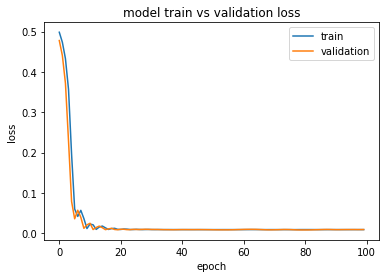

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [ ]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)

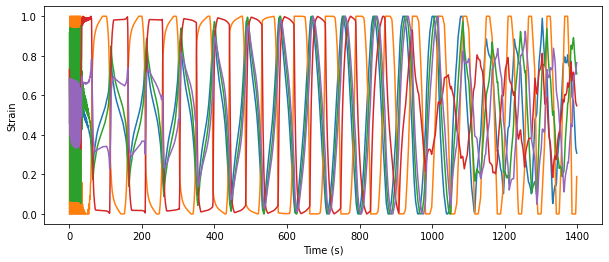

In [45]:
import pylab 
pylab.figure(figsize=(10,4))
for x in range(0,5):
  pylab.plot(X_test[x])
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

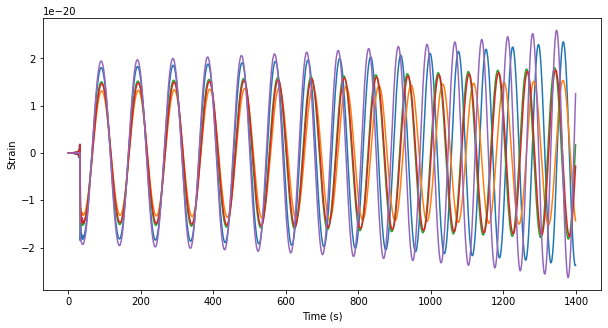

In [18]:
import pylab 
pylab.figure(figsize=(10,5))
for x in range(5):
  pylab.plot(X_train[x])
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()